In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import qiskit
from qiskit import *
from math import pi
from qiskit.test.mock import FakeLondon
from qiskit import Aer
from qiskit import aqua
from NoiseModel import generateDepolarizingError, generateRelaxationError, generateNoiseModel
from qiskit.visualization import plot_histogram
import math
import cmath

t=1
U=1
machine = FakeLondon()
simulator = Aer.get_backend('qasm_simulator')
noise_model1 = generateNoiseModel(machine, coherent = False, incoherent = False, readout= False)
noise_model2 = generateNoiseModel(machine, coherent = False, incoherent = False, readout= True)
noise_model3 = generateNoiseModel(machine, coherent = False, incoherent = True, readout= False)
noise_model4 = generateNoiseModel(machine, coherent = True, incoherent = False, readout= False)

Original: 0.01 0.050000000000000044
Reverse: 0.01 0.050000000000000044
Original: 0.02 0.07666666666666666
Reverse: 0.02 0.07666666666666666
Original: 0.14 0.18999999999999995
Reverse: 0.14 0.18999999999999995
Original: 0.0033333333333332993 0.03
Reverse: 0.0033333333333332993 0.03
Original: 0.006666666666666667 0.043333333333333335
Reverse: 0.006666666666666667 0.043333333333333335


In [3]:
#dummy parameters
phi = pi/4
theta = pi/4

# Circuit

Lets make a function out of this which takes in a value for gamma and outputs the circuit with gamma = that value

In [4]:
def get_hopping_circ(phi, theta):
    
    qreg_q = QuantumRegister(4, 'q')
    creg_c = ClassicalRegister(4, 'c')
    circuit = QuantumCircuit(qreg_q, creg_c)

    # Initialization
    circuit.x(qreg_q[0])
    circuit.x(qreg_q[2])
    circuit.cx(qreg_q[0], qreg_q[1])
    circuit.cx(qreg_q[2], qreg_q[3])
    circuit.cry(-pi/2, qreg_q[1], qreg_q[0])
    circuit.cry(-pi/2, qreg_q[3], qreg_q[2])
    circuit.cx(qreg_q[0], qreg_q[1])
    circuit.cx(qreg_q[2], qreg_q[3])

    # Barrier
    circuit.barrier(qreg_q[0], qreg_q[1], qreg_q[2], qreg_q[3])

    # Ansatz
    circuit.crz(phi, qreg_q[2], qreg_q[0])
    circuit.crz(phi, qreg_q[3], qreg_q[1])
    circuit.cx(qreg_q[0], qreg_q[1])
    circuit.cx(qreg_q[2], qreg_q[3])
    circuit.crx(theta, qreg_q[1], qreg_q[0])
    circuit.crx(theta, qreg_q[3], qreg_q[2])
    circuit.cx(qreg_q[0], qreg_q[1])
    circuit.cx(qreg_q[2], qreg_q[3])


    # Barrier
    circuit.barrier(qreg_q[0], qreg_q[1], qreg_q[2], qreg_q[3])

    # Diagonalization
    circuit.cx(qreg_q[0], qreg_q[1])
    circuit.cx(qreg_q[2], qreg_q[3])
    circuit.ch(qreg_q[1], qreg_q[0])
    circuit.ch(qreg_q[3], qreg_q[2])
    circuit.cx(qreg_q[0], qreg_q[1])
    circuit.cx(qreg_q[2], qreg_q[3])
    
    # Barrier
    circuit.barrier(qreg_q[0], qreg_q[1], qreg_q[2], qreg_q[3])
    
    
    # Measurement
    circuit.measure(qreg_q[0], creg_c[0])
    circuit.measure(qreg_q[1], creg_c[1])
    circuit.measure(qreg_q[2], creg_c[2])
    circuit.measure(qreg_q[3], creg_c[3])
    
    return circuit

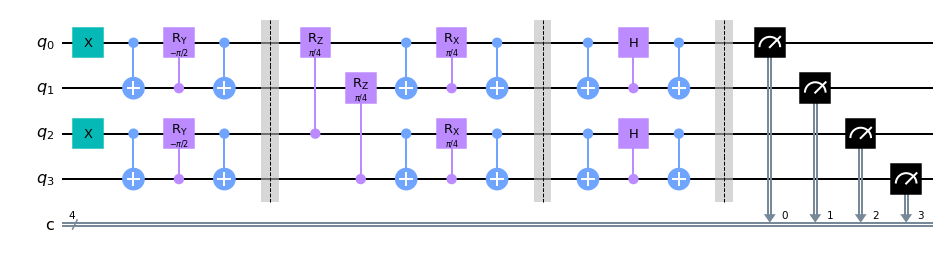

In [5]:
get_hopping_circ(phi, theta).draw('mpl')

In [6]:
def get_onsite_circ(phi, theta):
    
    qreg_q = QuantumRegister(4, 'q')
    creg_c = ClassicalRegister(4, 'c')
    circuit = QuantumCircuit(qreg_q, creg_c)

    # Initialization
    circuit.x(qreg_q[0])
    circuit.x(qreg_q[2])
    circuit.cx(qreg_q[0], qreg_q[1])
    circuit.cx(qreg_q[2], qreg_q[3])
    circuit.cry(-pi/2, qreg_q[1], qreg_q[0])
    circuit.cry(-pi/2, qreg_q[3], qreg_q[2])
    circuit.cx(qreg_q[0], qreg_q[1])
    circuit.cx(qreg_q[2], qreg_q[3])

    # Barrier
    circuit.barrier(qreg_q[0], qreg_q[1], qreg_q[2], qreg_q[3])

    # Ansatz
    circuit.crz(phi, qreg_q[2], qreg_q[0])
    circuit.crz(phi, qreg_q[3], qreg_q[1])
    circuit.cx(qreg_q[0], qreg_q[1])
    circuit.cx(qreg_q[2], qreg_q[3])
    circuit.crx(theta, qreg_q[1], qreg_q[0])
    circuit.crx(theta, qreg_q[3], qreg_q[2])
    circuit.cx(qreg_q[0], qreg_q[1])
    circuit.cx(qreg_q[2], qreg_q[3])


    # Barrier
    circuit.barrier(qreg_q[0], qreg_q[1], qreg_q[2], qreg_q[3])
    
    # Measurement
    circuit.measure(qreg_q[0], creg_c[0])
    circuit.measure(qreg_q[1], creg_c[1])
    circuit.measure(qreg_q[2], creg_c[2])
    circuit.measure(qreg_q[3], creg_c[3])
    
    return circuit

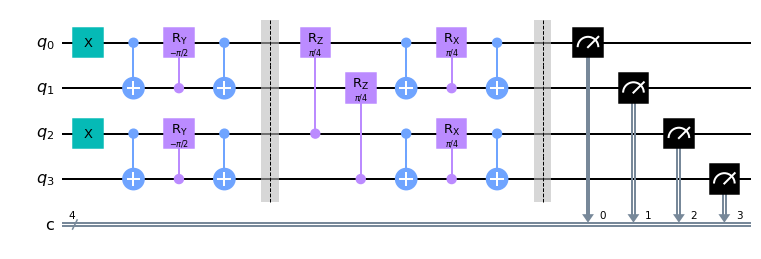

In [7]:
get_onsite_circ(phi, theta).draw('mpl')

# Measuring the circuit
We're gonna define some objective function/energy that has to be calculated using the resulting counts from the function

In [8]:
def get_hopping_counts(arr, noise_model):
    circ = get_hopping_circ(arr[0], arr[1])
    backend = Aer.get_backend('qasm_simulator')
    job = execute(circ, backend, noise_model = noise_model, shots = 8192)
    counts = job.result().get_counts()
    return counts

In [9]:
def get_onsite_counts(arr, noise_model):
    circ = get_onsite_circ(arr[0], arr[1])
    backend = Aer.get_backend('qasm_simulator')
    job = execute(circ, backend, noise_model = noise_model, shots = 8192)
    counts = job.result().get_counts()
    return counts

In [10]:
def new_counts(counts):
    counts_new = counts

    return counts_new

In [11]:
def new_counts_mitigated(counts):
    counts_new = {}
     
    for key in counts:
        if key=='0101' or key=='1010' or key=='0110' or key=='1001':
            if counts_new.get(key) != None:
                counts_new[key]=counts_new[key]+counts.get(key)
            else:
                counts_new[key] = counts.get(key)

    return counts_new

In [12]:
def find_energy(counts1, counts2):
    energy1 = -t*((counts1.get('1010', 0)+counts1.get('0110', 0))-(counts1.get('1001', 0)+counts1.get('0101', 0))+(counts1.get('1010', 0)+counts1.get('1001', 0))-(counts1.get('0110', 0)+counts1.get('0101', 0)))/sum(counts1.values())
    energy2 = U*(counts2.get('1010', 0)+counts2.get('0101', 0))/sum(counts2.values())
    return energy1 + energy2

##### Ready to Optimize

In [13]:
def f1(arr):
    counts1 = get_hopping_counts(arr, noise_model1)
    counts2 = get_onsite_counts(arr, noise_model1)
    counts1_new = new_counts(counts1)
    counts2_new = new_counts(counts2)
    return find_energy(counts1_new, counts2_new)

In [14]:
def f2(arr):
    counts1 = get_hopping_counts(arr, noise_model2)
    counts2 = get_onsite_counts(arr, noise_model2)
    counts1_new = new_counts_mitigated(counts1)
    counts2_new = new_counts_mitigated(counts2)
    return find_energy(counts1_new, counts2_new)

In [15]:
def f3(arr):
    counts1 = get_hopping_counts(arr, noise_model3)
    counts2 = get_onsite_counts(arr, noise_model3)
    counts1_new = new_counts_mitigated(counts1)
    counts2_new = new_counts_mitigated(counts2)
    return find_energy(counts1_new, counts2_new)

In [16]:
def f4(arr):
    counts1 = get_hopping_counts(arr, noise_model4)
    counts2 = get_onsite_counts(arr, noise_model4)
    counts1_new = new_counts_mitigated(counts1)
    counts2_new = new_counts_mitigated(counts2)
    return find_energy(counts1_new, counts2_new)

We will use COBYLA. I'm not sure how it works. My buest guess is it uses some approach and once successive iterations produce values in the same region, it stops

In [17]:
from scipy.optimize import minimize
import numpy as np
import random
from scipy.optimize import minimize
from qiskit.algorithms.optimizers import SPSA
import numpy as np
import random
import statistics

In [18]:
iterations1 = []
parameters1 = []
values1 = []
iterations2 = []
parameters2 = []
values2 = []
iterations3 = []
parameters3 = []
values3 = []
iterations4 = []
parameters4 = []
values4 = []

def callback_fn1(iteration, parameter, value, stepsize, accepted):
    if (accepted):
        iterations1.append(iteration/3)
        parameters1.append(parameter)
        values1.append(value)
        
def callback_fn2(iteration, parameter, value, stepsize, accepted):
    if (accepted):
        iterations2.append(iteration/3)
        parameters2.append(parameter)
        values2.append(value)

def callback_fn3(iteration, parameter, value, stepsize, accepted):
    if (accepted):
        iterations3.append(iteration/3)
        parameters3.append(parameter)
        values3.append(value)

def callback_fn4(iteration, parameter, value, stepsize, accepted):
    if (accepted):
        iterations4.append(iteration/3)
        parameters4.append(parameter)
        values4.append(value)
    
    
true = (-math.sqrt(17)+1)/2
    
spsa1 = SPSA(maxiter=200, callback=callback_fn1)
param1, value1, nefv1 = spsa1.optimize(num_vars=2, objective_function=f1, gradient_function=None, variable_bounds=None, initial_point=np.array([0, 0.1]))

spsa2 = SPSA(maxiter=200, callback=callback_fn2)
param2, value2, nefv2 = spsa2.optimize(num_vars=2, objective_function=f2, gradient_function=None, variable_bounds=None, initial_point=np.array([0, 0.1]))

spsa3 = SPSA(maxiter=200, callback=callback_fn3)
param3, value3, nefv3 = spsa3.optimize(num_vars=2, objective_function=f3, gradient_function=None, variable_bounds=None, initial_point=np.array([0, 0.1]))

spsa4 = SPSA(maxiter=200, callback=callback_fn4)
param4, value4, nefv4 = spsa4.optimize(num_vars=2, objective_function=f4, gradient_function=None, variable_bounds=None, initial_point=np.array([0, 0.1]))

avg1 = 0
new_arr1 = []
avg2 = 0
new_arr2 = []
avg3 = 0
new_arr3 = []
avg4 = 0
new_arr4 = []

for i in range(len(values1)-100, len(values1)):
    avg1 += values1[i]
    new_arr1.append(values1[i])
avg1 /= 100
    
    
for i in range(len(values2)-100, len(values2)):
    avg2 += values2[i]
    new_arr2.append(values2[i])
avg2 /= 100

for i in range(len(values3)-100, len(values3)):
    avg3 += values3[i]
    new_arr3.append(values3[i])
avg3 /= 100

for i in range(len(values4)-100, len(values4)):
    avg4 += values4[i]
    new_arr4.append(values4[i])
avg4 /= 100


phi1 = param1[0]
theta1 = param1[1]
energy_diff1 = value1-true
avg_diff1 = avg1-true
stdev1 = statistics.stdev(new_arr1)

phi2 = param2[0]
theta2 = param2[1]
energy_diff2 = value2-true
avg_diff2 = avg2-true
stdev2 = statistics.stdev(new_arr2)

phi3 = param2[0]
theta3 = param2[1]
energy_diff3 = value3-true
avg_diff3 = avg3-true
stdev3 = statistics.stdev(new_arr3)

phi4 = param4[0]
theta4 = param4[1]
energy_diff4 = value4-true
avg_diff4 = avg4-true
stdev4 = statistics.stdev(new_arr4)

In [19]:
%store energy_diff1
%store phi1
%store theta1
%store energy_diff2
%store phi2
%store theta2
%store iterations1
%store parameters1
%store values1
%store iterations2
%store parameters2
%store values2

Stored 'energy_diff1' (float)
Stored 'phi1' (float64)
Stored 'theta1' (float64)
Stored 'energy_diff2' (float)
Stored 'phi2' (float64)
Stored 'theta2' (float64)
Stored 'iterations1' (list)
Stored 'parameters1' (list)
Stored 'values1' (list)
Stored 'iterations2' (list)
Stored 'parameters2' (list)
Stored 'values2' (list)


In [20]:
print("Energy Difference: ", energy_diff1)
print("Average Difference: ", avg_diff1)
print("Standard Deviation: ", stdev1)
print("Phi: ", phi1)
print("Theta: ", theta1)
print("Phi: ", phi1%(2*pi))
print("Theta: ", theta1%(2*pi))

Energy Difference:  0.003691484683830293
Average Difference:  0.00038459991820527506
Standard Deviation:  0.007108700945040447
Phi:  -6.498716307750597
Theta:  -3.934339495626307
Phi:  6.067654306608575
Theta:  2.348845811553279


In [21]:
print("Energy Difference: ", energy_diff2)
print("Average Difference: ", avg_diff2)
print("Standard Deviation: ", stdev2)
print("Phi: ", phi2)
print("Theta: ", theta2)
print("Phi: ", phi2%(2*pi))
print("Theta: ", theta2%(2*pi))

Energy Difference:  0.03113626624872512
Average Difference:  0.012579500236799879
Standard Deviation:  0.008807646147619056
Phi:  -0.2673569935711668
Theta:  21.162540847622953
Phi:  6.015828313608419
Theta:  2.3129849260841944


In [22]:
print("Energy Difference: ", energy_diff3)
print("Average Difference: ", avg_diff3)
print("Standard Deviation: ", stdev3)
print("Phi: ", phi3)
print("Theta: ", theta3)
print("Phi: ", phi3%(2*pi))
print("Theta: ", theta3%(2*pi))

Energy Difference:  0.05810175494126302
Average Difference:  0.038314749016956196
Standard Deviation:  0.00900833069221227
Phi:  -0.2673569935711668
Theta:  21.162540847622953
Phi:  6.015828313608419
Theta:  2.3129849260841944


In [23]:
print("Energy Difference: ", energy_diff4)
print("Average Difference: ", avg_diff4)
print("Standard Deviation: ", stdev4)
print("Phi: ", phi4)
print("Theta: ", theta4)
print("Phi: ", phi4%(2*pi))
print("Theta: ", theta4%(2*pi))

Energy Difference:  0.04847581000468404
Average Difference:  0.06837721181023215
Standard Deviation:  0.008733659864724096
Phi:  -0.2585986503871738
Theta:  5.495761558470677
Phi:  6.024586656792413
Theta:  5.495761558470677


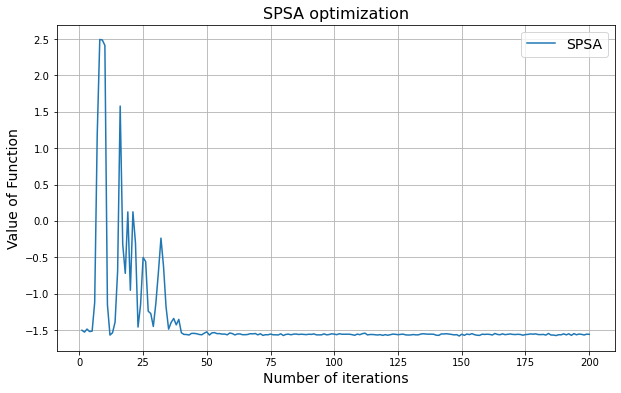

In [24]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(iterations1, values1, label="SPSA")
plt.xlabel("Number of iterations", fontsize=14)
plt.ylabel("Value of Function", fontsize=14)
plt.grid()

plt.title("SPSA optimization", fontsize=16)
plt.legend(fontsize=14)
plt.show()
plt.show()

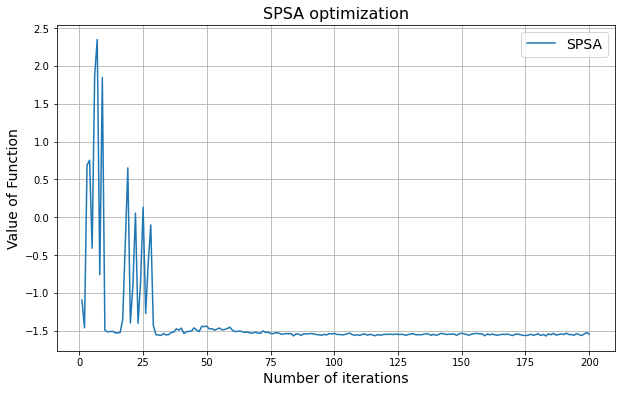

In [25]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(iterations2, values2, label="SPSA")
plt.xlabel("Number of iterations", fontsize=14)
plt.ylabel("Value of Function", fontsize=14)
plt.grid()

plt.title("SPSA optimization", fontsize=16)
plt.legend(fontsize=14)
plt.show()
plt.show()

In [26]:
for i in range(len(new_arr1)):
    new_arr1[i] -= true
for i in range(len(new_arr2)):
    new_arr2[i] -= true
for i in range(len(new_arr3)):
    new_arr3[i] -= true
for i in range(len(new_arr4)):
    new_arr4[i] -= true

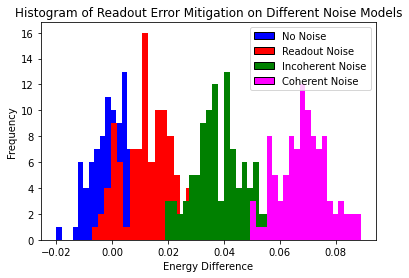

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

a = plt.figure()
plt.hist(new_arr1, bins=20, color = "blue")
plt.hist(new_arr2, bins=20, color = "red")
plt.hist(new_arr3, bins=20, color = "green")
plt.hist(new_arr4, bins=20, color = "magenta")

colors = ["blue", "red", "green", "magenta"]
handles = [Rectangle((0, 0), 1, 1, color=c, ec="k") for c in colors]
labels = ["No Noise", "Readout Noise", "Incoherent Noise", "Coherent Noise"]
plt.legend(handles, labels)

plt.title("Histogram of Readout Error Mitigation on Different Noise Models")
plt.xlabel("Energy Difference")
plt.ylabel("Frequency")
plt.show()
#a.savefig('Normal(1).png', dpi = 1000)